In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from osgeo import gdal
from osgeo.osr import SpatialReference, CoordinateTransformation
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
import pydot
import importlib
import time
# TODO: set up better environment so module edits are automatically reloaded
import UtilityFunctions as util
importlib.reload(util)

<module 'UtilityFunctions' from '/Users/philt/Desktop/CS 4860/forest_fire_regrowth_analysis/UtilityFunctions.py'>

In [13]:
# convert .tif files in a folder to a .csv
# util.convert_tif_folder_to_csv('RimFire_AVIRIS_20131117')

opening RimFire_AVIRIS_20131117_L3v1-mSAVI.tif
flattening array shape (2935, 3399) to 1D array
opening RimFire_AVIRIS_20131117_L3v1-NDNI.tif
flattening array shape (2935, 3399) to 1D array
opening RimFire_AVIRIS_20131117_L3v1-WBI.tif
flattening array shape (2935, 3399) to 1D array
opening RimFire_AVIRIS_20131117_L3v1-PSRI.tif
flattening array shape (2935, 3399) to 1D array
opening RimFire_AVIRIS_20131117_L3v1-NDVI.tif
flattening array shape (2935, 3399) to 1D array
opening RimFire_AVIRIS_20131117_L3v1-CSI.tif
flattening array shape (2935, 3399) to 1D array
opening RimFire_AVIRIS_20131117_L3v1-MSI.tif
flattening array shape (2935, 3399) to 1D array
opening RimFire_AVIRIS_20131117_L3v1-NBR.tif
flattening array shape (2935, 3399) to 1D array
opening RimFire_AVIRIS_20131117_L3v1-ARI1.tif
flattening array shape (2935, 3399) to 1D array
opening RimFire_AVIRIS_20131117_L3v1-ARI2.tif
flattening array shape (2935, 3399) to 1D array
opening RimFire_AVIRIS_20131117_L3v1-mCARI.tif
flattening array

In [2]:
# get csv into dataframe and remove invalid measurements
df = pd.read_csv('RimFire_AVIRIS_20131117.csv').astype(np.float32)
df.replace(-9999.0, float('nan'), inplace=True)
# copy the dataframe
df_copy = df.copy()
# Replace infinite values with nan in 'CSI' band
df_copy.loc[np.isinf(df_copy['CSI']), 'CSI'] = np.nan
# band names - column headers
band_names = df.columns[:-1]
band_names_copy = df_copy.columns[:-1]

<class 'numpy.float32'>


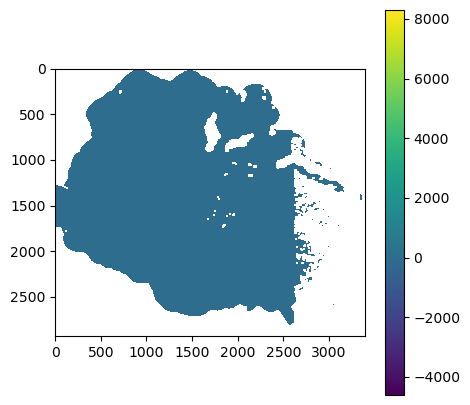

In [3]:
# df = pd.read_csv('RimFire_AVIRIS_20131117.csv')
# df.replace(-9999.0, float('nan'), inplace=True)
# print(df.head)
# Get list of band names from dataframe column names

nbr = df['NBR'].to_numpy()
nbr_matrix = nbr.reshape(2935, 3399)
print(type(nbr_matrix[0][0]))
plt.figure(figsize=(5, 5))
plt.imshow(nbr_matrix)
plt.colorbar()

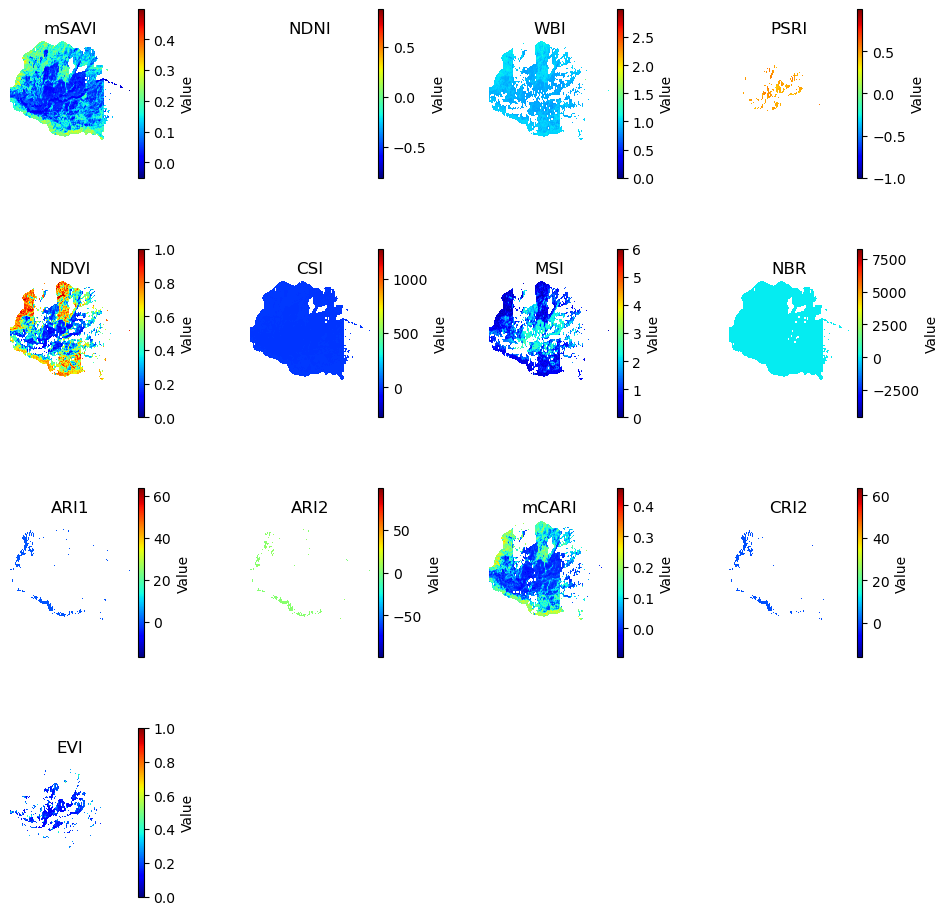

In [4]:
# Show heatmap of all bands

# Get list of band names from dataframe column names
band_names = df.columns[:-1]

# Determine the number of rows and columns for subplots
num_bands = len(band_names)
num_rows = math.ceil(math.sqrt(num_bands))
num_cols = math.ceil(num_bands / num_rows)

# Plot each band in a separate subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
fig.tight_layout(pad=3.0)  # Adjust spacing between subplots

for i, band_name in enumerate(band_names):
    row = i // num_cols
    col = i % num_cols

    band = df[band_name].to_numpy()
    band_matrix = band.reshape(2935, 3399)

    img = axes[row, col].imshow(band_matrix, cmap='jet')
    axes[row, col].set_title(band_name)
    axes[row, col].axis('off')

    # Add colorbar
    cbar = fig.colorbar(img, ax=axes[row, col], aspect=30, pad=0.05)
    cbar.set_label('Value')

# Remove empty subplots
if num_bands < num_rows * num_cols:
    for i in range(num_bands, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.show()

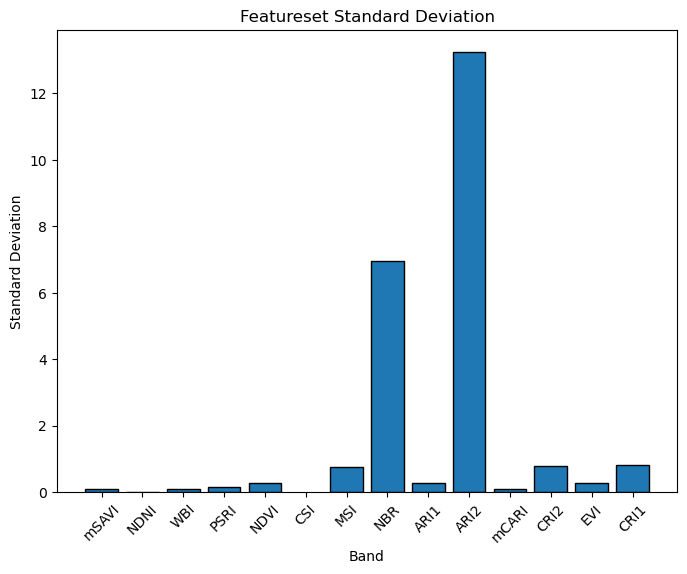

In [5]:
# plot standard deviation

# Assuming df is your raw pandas DataFrame with the bands
std_dev = df.std()  # Compute the standard deviation for each band

plt.figure(figsize=(8, 6))
plt.bar(range(len(std_dev)), std_dev, align='center', edgecolor='black')
plt.xlabel('Band')
plt.ylabel('Standard Deviation')
plt.title('Featureset Standard Deviation')
plt.xticks(range(len(std_dev)), std_dev.index, rotation=45)
plt.show()

In [6]:
# normalizd necessary bands

# Create MinMaxScaler instances for different ranges
neg_one_to_one_scalar = MinMaxScaler(feature_range=(-1, 1))
zero_to_one_scalar = MinMaxScaler(feature_range=(0, 1))

# Columns to be normalized to [-1, 1]
columns_neg_one_to_one = ['NBR', 'ARI2']
for column in columns_neg_one_to_one:
    values = df_copy[column].values
    valid_values = values[~np.isnan(values)]  # Exclude 'nan' values
    # column_data = df_copy[column]
    # df_copy[column] = neg_one_to_one_scalar.fit_transform(np.array(df_copy[column]).reshape(-1, 1))
    # if len(valid_values) > 0:
    min_value = np.min(valid_values)
    max_value = np.max(valid_values)

    # df_copy.loc[~np.isnan(df_copy[column]), column] = (df_copy[column] - min_value) / (max_value - min_value)
    df_copy.loc[~np.isnan(df_copy[column]), column] = 2 * ((df_copy[column] - min_value) / (max_value - min_value)) - 1
    min_value = df_copy[column].min()
    max_value = df_copy[column].max()
    mean_value = df_copy[column].mean()
    print(f"{column} - Min: {min_value}, Max: {max_value}, Mean: {mean_value}")

# Columns to be normalized to [0, 1]
columns_zero_to_one = ['ARI1', 'CRI2','CSI']
for column in columns_zero_to_one:
    # column_data = df_copy[column]
    df_copy[column] = zero_to_one_scalar.fit_transform(np.array(df_copy[column]).reshape(-1, 1))
    min_value = np.min(valid_values)
    max_value = np.max(valid_values)

    min_value = df_copy[column].min()
    max_value = df_copy[column].max()
    mean_value = df_copy[column].mean()
    print(f"{column} - Min: {min_value}, Max: {max_value}, Mean: {mean_value}")

NBR - Min: -1.0, Max: 1.0, Mean: -0.28577083349227905
ARI2 - Min: -1.0, Max: 1.0, Mean: 0.04959410801529884
ARI1 - Min: 0.0, Max: 1.0, Mean: 0.20739217102527618
CRI2 - Min: 0.0, Max: 1.0, Mean: 0.20039694011211395
CSI - Min: 0.0, Max: 1.0, Mean: 0.17977020144462585


In [7]:
first_non_nan_index = df_copy['NBR'].first_valid_index()
first_non_nan_value = df_copy.loc[first_non_nan_index, 'NBR']
print(first_non_nan_value)

-0.28574055


NBR - Min: -1.0, Max: 1.0, Mean: -0.28577083349227905
<class 'numpy.float32'>
ARI2 - Min: -1.0, Max: 1.0, Mean: 0.04959410801529884
<class 'numpy.float32'>
ARI1 - Min: 0.0, Max: 1.0, Mean: 0.20739217102527618
<class 'numpy.float32'>
CRI2 - Min: 0.0, Max: 1.0, Mean: 0.20039694011211395
<class 'numpy.float32'>
CSI - Min: 0.0, Max: 1.0, Mean: 0.17977020144462585
<class 'numpy.float32'>


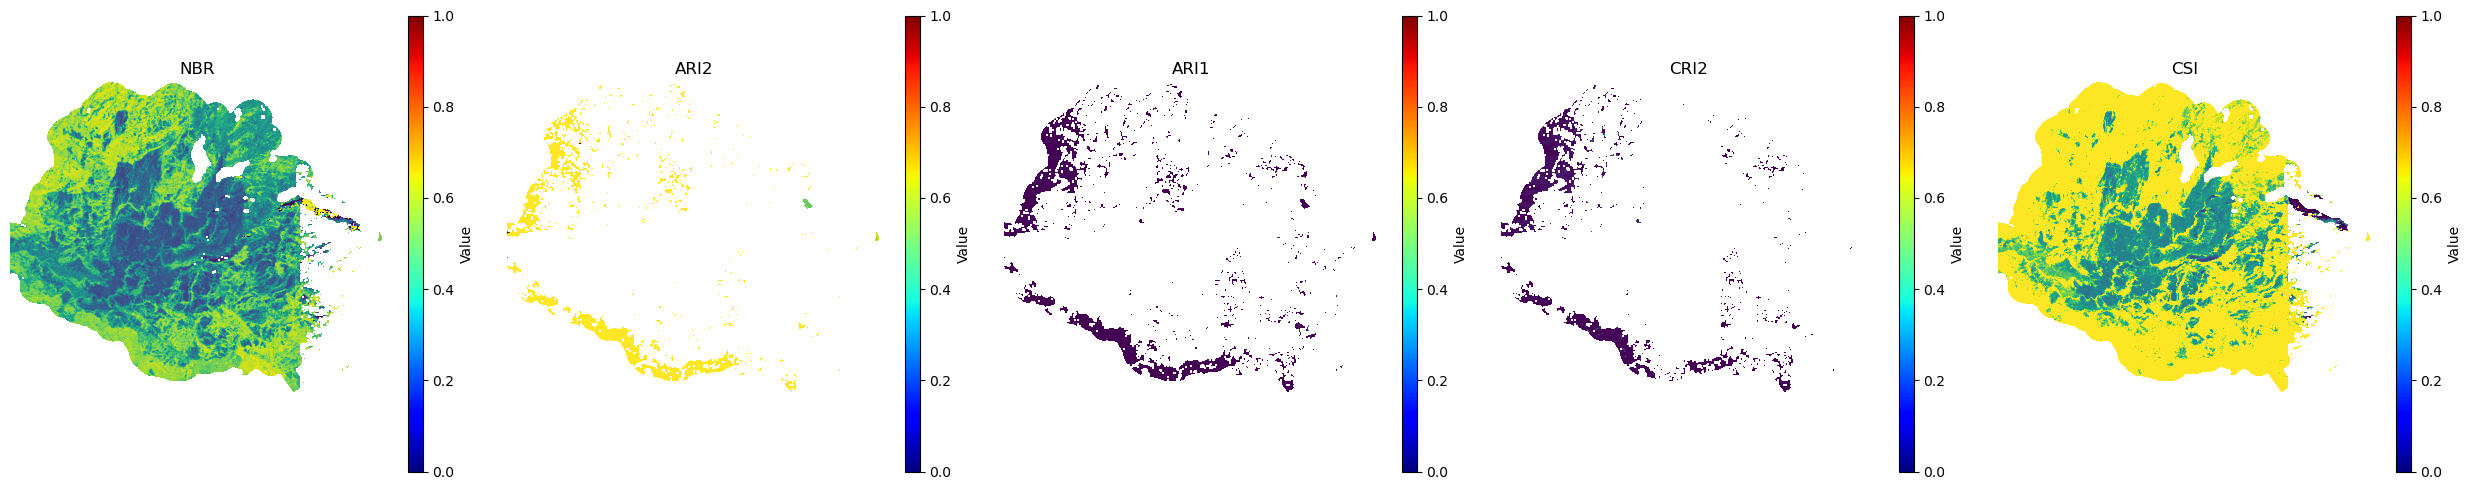

In [8]:
# show heatmap figure for normalized values

# List of columns to plot
columns = ['NBR', 'ARI2', 'ARI1', 'CRI2', 'CSI']

# Calculate the number of rows and columns for subplots
num_rows = 1
num_cols = len(columns)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5))

# Iterate over each column
for i, column in enumerate(columns):
    min_value = df_copy[column].min()
    max_value = df_copy[column].max()
    mean_value = df_copy[column].mean()
    print(f"{column} - Min: {min_value}, Max: {max_value}, Mean: {mean_value}")
    nbr = df[column].to_numpy()
    nbr_matrix = nbr.reshape(2935, 3399)
    print(type(nbr_matrix[0][0]))
    axes[i].imshow(nbr_matrix, vmin=min_value, vmax=max_value)
    axes[i].set_title(column)
    axes[i].axis('off')
    # Add colorbar
    cbar = fig.colorbar(img, ax=axes[i], aspect=30, pad=0.05)
    cbar.set_label('Value')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [9]:
# Remove NDNI from dataset and verify its gone
df.drop('NDNI', axis=1, inplace=True)
df.head()

,mSAVI,WBI,PSRI,NDVI,CSI,MSI,NBR,ARI1,ARI2,mCARI,CRI2,EVI,CRI1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Train first model RF1

num_trees = 100
# Split the data into features (X) and label (y)
X_1 = df_copy[['mSAVI', 'WBI', 'PSRI', 'NDVI', 'CSI', 'MSI', 'ARI1', 'ARI2', 'mCARI', 'CRI2', 'EVI', 'CRI1']]
y = df_copy['NBR']

# Drop rows with missing values in both X1 and y
combined_df = X_1.copy()
combined_df['NBR'] = y
combined_df.dropna(inplace=True)
X_1 = combined_df.drop('NBR', axis=1)
y_1 = combined_df['NBR']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

# Create the SimpleImputer to handle missing values (NaN)
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training set and transform both training and testing sets
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Create the Random Forest regressor
rf1 = RandomForestRegressor(n_estimators=num_trees, max_features='sqrt')

# Train the model
rf1.fit(X_train_imputed, y_train)

# Predict on the test set
y_pred = rf1.predict(X_test_imputed)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RF1 Results: ")
print("===========================")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


RF1 Results: 
Mean Squared Error: 1.3443650714474775e-10
R-squared: 0.8857463893485172


In [11]:
# Train first model RF1

num_trees = 150
# Split the data into features (X) and label (y)
X_1 = df_copy[['mSAVI', 'WBI', 'PSRI', 'NDVI', 'CSI', 'MSI', 'ARI1', 'ARI2', 'mCARI', 'CRI2', 'EVI', 'CRI1']]
y = df_copy['NBR']

# Drop rows with missing values in both X1 and y
combined_df = X_1.copy()
combined_df['NBR'] = y
combined_df.dropna(inplace=True)
X_1 = combined_df.drop('NBR', axis=1)
y_1 = combined_df['NBR']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

# Create the SimpleImputer to handle missing values (NaN)
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training set and transform both training and testing sets
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Create the Random Forest regressor
rf1 = RandomForestRegressor(n_estimators=num_trees, max_features='sqrt')

# Train the model
rf1.fit(X_train_imputed, y_train)

# Predict on the test set
y_pred = rf1.predict(X_test_imputed)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RF1 Results: ")
print("===========================")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


RF1 Results: 
Mean Squared Error: 1.33664532500583e-10
R-squared: 0.8864024677627849


In [12]:
# Train first model RF1

num_trees = 200
# Split the data into features (X) and label (y)
X_1 = df_copy[['mSAVI', 'WBI', 'PSRI', 'NDVI', 'CSI', 'MSI', 'ARI1', 'ARI2', 'mCARI', 'CRI2', 'EVI', 'CRI1']]
y = df_copy['NBR']

# Drop rows with missing values in both X1 and y
combined_df = X_1.copy()
combined_df['NBR'] = y
combined_df.dropna(inplace=True)
X_1 = combined_df.drop('NBR', axis=1)
y_1 = combined_df['NBR']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

# Create the SimpleImputer to handle missing values (NaN)
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training set and transform both training and testing sets
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Create the Random Forest regressor
rf1 = RandomForestRegressor(n_estimators=num_trees, max_features='sqrt')

# Train the model
rf1.fit(X_train_imputed, y_train)

# Predict on the test set
y_pred = rf1.predict(X_test_imputed)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RF1 Results: ")
print("===========================")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


RF1 Results: 
Mean Squared Error: 1.3337597860548874e-10
R-squared: 0.886647701182503


In [15]:
# calculate feature importances
start_time = time.time()
importances = rf1.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf1.estimators_], axis=0)
elapsed_time = time.time() - start_time
feature_names = X_1.columns.tolist()

[0.05444428 0.0378262  0.046838   0.02214659 0.14839093 0.40199238
 0.02961323 0.03622928 0.100769   0.02436232 0.0243545  0.0730333 ]


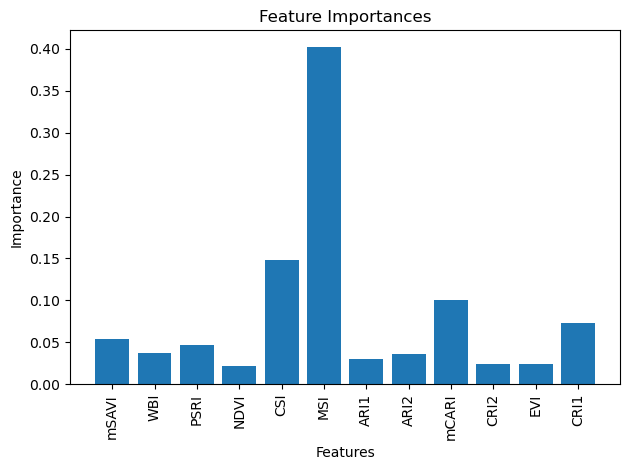

In [17]:
# Create a histogram
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
print(importances)
# Show the plot
plt.show()

[26  4 10  0  1 45 12  8 51  3  3 37]


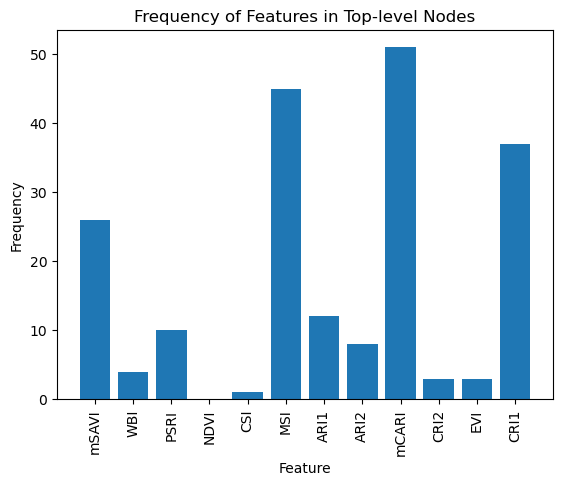

In [16]:
# Get the feature indices in the top-level nodes of all decision trees
top_features = [tree.tree_.feature[0] for tree in rf1.estimators_]

# Calculate the frequency of each feature
feature_counts = np.bincount(top_features)
print(feature_counts)
# Plot the histogram
plt.bar(feature_names, feature_counts)
plt.xlabel("Feature")
plt.ylabel("Frequency")
plt.title("Frequency of Features in Top-level Nodes")
plt.xticks(rotation=90)
plt.show()

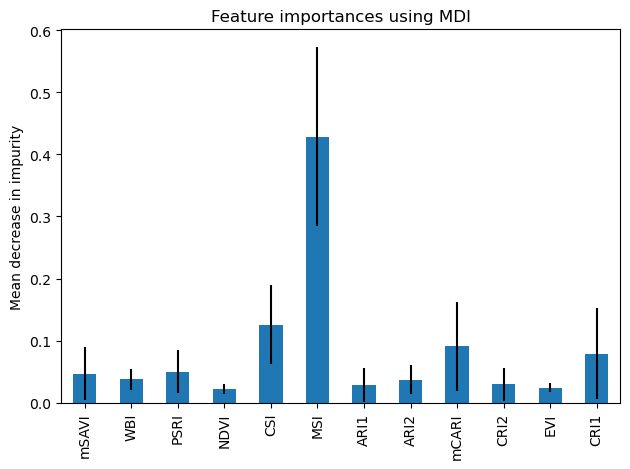

In [246]:
# plot Mean Decrease in Impurity
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()